# Process the deep mutational scanning data

The data come from the following papers from Yunlong Cao's group:

 - [Imprinted SARS-CoV-2 humoral immunity induces convergent Omicron RBD evolution (2022)](https://www.nature.com/articles/s41586-022-05644-7)
 
 - [Repeated Omicron infection alleviates SARS-CoV-2 immune imprinting (2023)](https://www.biorxiv.org/content/10.1101/2023.05.01.538516v2)

In [1]:
import math
import os

import matplotlib.pyplot as plt

import pandas as pd

## Process data from [Repeated Omicron infection alleviates SARS-CoV-2 immune imprinting (2023)](https://www.biorxiv.org/content/10.1101/2023.05.01.538516v2)

In [2]:
# read the data
repeated_2023_info = (
    pd.read_csv("Cao_data/SARS-CoV-2-reinfection-DMS/antibody_info.csv")
    .rename(columns={"Unnamed: 0": "antibody"})
).assign(study="repeated_2023")

assert len(repeated_2023_info) == repeated_2023_info["antibody"].nunique()

# get the antibody sources
repeated_2023_source = repeated_2023_info[["antibody", "source", "study"]]

print("Number of antibodies from each source:")
display(
    repeated_2023_source
    .groupby(["study", "source"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

# get the IC50s
repeated_2023_ic50s = (
    repeated_2023_info
    .melt(
        id_vars=["study", "antibody"],
        value_vars=[c for c in repeated_2023_info if c.endswith("_IC50")],
        var_name="virus",
        value_name="IC50",
    )
    .query("IC50.notnull()")  # no data, 10 means non-neutralizing
    .assign(
        virus=lambda x: x["virus"].str.replace("_IC50", "").map({
            "D614G": "D614G",
            "BA1": "BA.1",
            "BA2": "BA.2",
            "BA3": "BA.3",
            "SARS": "SARS",
            "BA1_1": "BA.1.1",
            "BA2_12_1": "BA.2.12.1",
            "BA2_75": "BA.2.75",
            "BA5": "BA.5",
            "BF7": "BF.7",
            "BA2_13": "BA.2.13",
            "BQ1_1": "BQ.1.1",
            "XBB": "XBB",
            "XBB1_5": "XBB.1.5",
            "XBB1_5_10": "XBB.1.5.10",
        }),
    )
)

print("\nNumber of IC50s per antibody:")
display(
    repeated_2023_ic50s
    .groupby("antibody", as_index=False)
    .aggregate(viruses_w_IC50s=pd.NamedAgg("virus", lambda s: "; ".join(s)))
    .groupby("viruses_w_IC50s")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

# get the binding reactivities
repeated_2023_binding = (
    repeated_2023_info
    .query("paper_reactivity != '--'")
    .assign(
        binds=lambda x: x["paper_reactivity"].map(
            {
                "WT": ["Wuhan-Hu-1"],
                "cross": ["Wuhan-Hu-1", "Omicron BA.2/BA.5"],
                "specific": ["Omicron BA.2/BA.5"],
            }
        )
    )
    [["study", "antibody", "binds"]]
    .explode("binds")
)

print("\nBinding targets per antibody:")
display(
    repeated_2023_binding
    .groupby("antibody", as_index=False)
    .aggregate(binds=pd.NamedAgg("binds", lambda s: "; ".join(s)))
    .groupby("binds")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

Number of antibodies from each source:


n_antibodies
study         source                                      
repeated_2023 BA.5 convalescents                       445
              BA.1 convalescents reinfection           284
              BF.7 convalescents                       243
              BA.2 convalescents reinfection           232
              BA.2 convalescents                        53
              long-term BA.1 convalescents              38
              BA.1 convalescents                        36
              WT convalescents                          12
              SARS convalescents                         5
              WT mouse                                   2


Number of IC50s per antibody:


,n_antibodies
viruses_w_IC50s,
D614G; BA.1; BA.2; SARS; BA.2.75; BA.5; BF.7; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,428
D614G; BA.1; BA.2; SARS; BA.2.75; BA.5; BF.7; BQ.1.1; XBB; XBB.1.5,181
D614G; BA.1; BA.2; BA.3; SARS; BA.1.1; BA.2.12.1; BA.2.75; BA.5; BA.2.13; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,137
D614G; BA.1; BA.2; SARS; BA.2.75; BA.5; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,130
D614G; BA.1; BA.2; BA.2.75; BA.5; BF.7; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,129
D614G; BA.1; BA.2; SARS; BA.2.75; BA.5; BQ.1.1; XBB; XBB.1.5,92
D614G; BA.1; BA.2; BA.2.75; BA.5; BQ.1.1; XBB; XBB.1.5,48
D614G; SARS; BA.5; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,42
D614G; BA.1; BA.2; BA.2.75; BA.5; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,34



Binding targets per antibody:


,n_antibodies
binds,
Wuhan-Hu-1; Omicron BA.2/BA.5,768
Omicron BA.2/BA.5,562
Wuhan-Hu-1,19


Now read the actual escape data, set max escape for each antibody to 1, and get total site escape:

In [3]:
repeated_2023_escape = (
    pd.read_csv("Cao_data/SARS-CoV-2-reinfection-DMS/antibody_dms_merge_clean.csv.gz")
    .groupby(["antibody", "site"], as_index=False)
    .aggregate(escape=pd.NamedAgg("mut_escape", "sum"))
    .assign(study="repeated_2023")
)

repeated_2023_escape.sort_values("escape")

,antibody,site,escape,study
45314,GC1852,390,5.628970e-08,repeated_2023
45311,GC1852,371,6.030392e-08,repeated_2023
45312,GC1852,373,6.448414e-08,repeated_2023
45323,GC1852,514,7.860392e-08,repeated_2023
45313,GC1852,377,9.080642e-08,repeated_2023
...,...,...,...,...
7512,GC0281,444,1.611308e+01,repeated_2023
4258,GC0177,346,1.637373e+01,repeated_2023
19760,GC0832,444,1.644617e+01,repeated_2023
4775,GC0191,444,1.648478e+01,repeated_2023


## Process data from [Imprinted SARS-CoV-2 humoral immunity induces convergent Omicron RBD evolution (2022)](https://www.nature.com/articles/s41586-022-05644-7)

In [4]:
# read the data, which is in multiple sheets
imprinted_2022_raw_info = pd.read_excel(
    "Cao_data/convergent_RBD_evolution/antibody_info.xlsx",
    header=1,
    sheet_name=None,
    usecols=lambda c: not c.startswith("Unnamed"),
)

common_cols = None

for sheetname, sheet in imprinted_2022_raw_info.items():
    columns = sheet.columns.tolist()
    if common_cols is None:
        common_cols = columns
    else:
        common_cols = [
            c for c in columns if c in set(common_cols).intersection(columns)
        ]

imprinted_2022_info = pd.concat(
    [
        sheet[common_cols].assign(sheet_name=sheet_name)
        for sheet_name, sheet in imprinted_2022_raw_info.items()
    ],
    ignore_index=True,
).rename(columns={"Antibody  Name": "antibody"}).assign(study="imprinted_2022")

assert len(imprinted_2022_info) == imprinted_2022_info["antibody"].nunique()

# get the antibody sources
imprinted_2022_source = imprinted_2022_info[["antibody", "source", "study"]]
display(
    imprinted_2022_source
    .groupby(["study", "source"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
)

# get the IC50s
imprinted_2022_ic50s = (
    imprinted_2022_info
    .melt(
        id_vars=["study", "antibody"],
        value_vars=["D614G", "BA.1", "BA.2", "BA.5", "BA.2.75", "BQ.1.1", "XBB"],
        var_name="virus",
        value_name="IC50",
    )
    # values of >10 to 10
    .query("IC50 != '--'")
    .assign(IC50=lambda x: x["IC50"].map(lambda ic50: 10 if ic50 == ">10" else float(ic50)))
)

print("\nNumber of IC50s per antibody:")
display(
    imprinted_2022_ic50s
    .groupby("antibody", as_index=False)
    .aggregate(viruses_w_IC50s=pd.NamedAgg("virus", lambda s: "; ".join(s)))
    .groupby("viruses_w_IC50s")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

# get the binding reactivities
imprinted_2022_binding = (
    imprinted_2022_info
    .assign(
        binds=lambda x: x["sheet_name"].map(
            {
                "cross": ["Wuhan-Hu-1", "Omicron BA.2/BA.5"],
                "specific": ["Omicron BA.2/BA.5"],
            }
        )
    )
    [["study", "antibody", "binds"]]
    .explode("binds")
)

print("\nBinding targets per antibody:")
display(
    imprinted_2022_binding
    .groupby("antibody", as_index=False)
    .aggregate(binds=pd.NamedAgg("binds", lambda s: "; ".join(s)))
    .groupby("binds")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

n_antibodies
study          source                          
imprinted_2022 BA.1 convalescents           752
               BA.2 convalescents           751
               BA.5 convalescents           269
               SARS convalescents           881
               WT convalescents             438
               WT vaccinees                 240
               WT-engineered                  2


Number of IC50s per antibody:


,n_antibodies
viruses_w_IC50s,
D614G; BA.1; BA.2; BA.5; BA.2.75; BQ.1.1; XBB,3309
D614G; BA.1; BA.2; BA.5; BA.2.75,13
D614G; BA.1; BA.2; BA.5; BA.2.75; BQ.1.1,3
D614G; BA.1; BA.2; BA.5; BA.2.75; XBB,3
BQ.1.1; XBB,2
BA.1; BA.2; BA.5; BA.2.75; BQ.1.1; XBB,1
BA.1; BQ.1.1; XBB,1
D614G; BQ.1.1; XBB,1



Binding targets per antibody:


,n_antibodies
binds,
Wuhan-Hu-1; Omicron BA.2/BA.5,3051
Omicron BA.2/BA.5,282


Now read the actual escape data, set max mutational escape to 1, and get total site escape:

In [5]:
imprinted_2022_escape = (
    pd.read_csv("Cao_data/convergent_RBD_evolution/use_res_clean.csv")
    .groupby(["antibody", "site"], as_index=False)
    .aggregate(escape=pd.NamedAgg("mut_escape", "sum"))
    .assign(study="imprinted_2022")
)

imprinted_2022_escape

,antibody,site,escape,study
0,1-57,338,0.521154,imprinted_2022
1,1-57,359,0.140217,imprinted_2022
2,1-57,370,0.285110,imprinted_2022
3,1-57,394,0.112732,imprinted_2022
4,1-57,396,0.194379,imprinted_2022
...,...,...,...,...
63387,XGv-422,465,0.769640,imprinted_2022
63388,XGv-422,466,0.886558,imprinted_2022
63389,XGv-422,468,0.313522,imprinted_2022
63390,XGv-422,484,0.165163,imprinted_2022


## Aggregate the antibody information from the different studies
First the antibody sources:

In [6]:
antibody_source = pd.concat(
    [repeated_2023_source, imprinted_2022_source],
    ignore_index=True,
)

print("Dropping the following antibodies duplicated across studies:")
display(antibody_source.groupby("antibody").tail(-1).reset_index(drop=True))

# keep just one of antibodies repeated across studies
antibody_source = antibody_source.groupby("antibody").first().reset_index()

print("\nRetained sources:")
display(antibody_source)

Dropping the following antibodies duplicated across studies:


,antibody,source,study
0,BD55-1205,WT convalescents,imprinted_2022
1,BD55-3372,SARS convalescents,imprinted_2022
2,BD55-4637,SARS convalescents,imprinted_2022
3,BD55-5483,SARS convalescents,imprinted_2022
4,BD55-5514,SARS convalescents,imprinted_2022
5,BD55-5840,SARS convalescents,imprinted_2022



Retained sources:


,antibody,source,study
0,1-57,WT convalescents,imprinted_2022
1,2-15,WT convalescents,imprinted_2022
2,7D6,WT convalescents,imprinted_2022
3,ADG-2,SARS convalescents,imprinted_2022
4,B38,WT convalescents,imprinted_2022
...,...,...,...
4672,XGv-416,WT vaccinees,imprinted_2022
4673,XGv-418,WT vaccinees,imprinted_2022
4674,XGv-420,WT vaccinees,imprinted_2022
4675,XGv-421,WT vaccinees,imprinted_2022


Now the IC50s:

In [7]:
antibody_ic50s = pd.concat(
    [repeated_2023_ic50s, imprinted_2022_ic50s],
    ignore_index=True,
)

# print("Dropping the following IC50s duplicated across studies:")
# display(antibody_ic50s.groupby(["antibody", "virus"]).tail(-1).reset_index(drop=True))

# keep just one of IC50s repeated across studies
antibody_ic50s = antibody_ic50s.groupby(["antibody", "virus"]).first().reset_index()

print("\nRetained IC50s:")
display(antibody_ic50s)

print("\nNumber of antibodies with no neutralization on any virus:")
assert antibody_ic50s["IC50"].dtype == float
display(
    antibody_ic50s
    .assign(non_neut=lambda x: x["IC50"] == 10)
    .groupby("antibody", as_index=False)
    .aggregate({"non_neut": "all"})
    .groupby("non_neut")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
)


Retained IC50s:


,antibody,virus,study,IC50
0,1-57,BA.1,imprinted_2022,10.000
1,1-57,BA.2,imprinted_2022,10.000
2,1-57,BA.2.75,imprinted_2022,10.000
3,1-57,BA.5,imprinted_2022,10.000
4,1-57,BQ.1.1,imprinted_2022,10.000
...,...,...,...,...
37180,XGv-422,BA.2.75,imprinted_2022,0.495
37181,XGv-422,BA.5,imprinted_2022,0.681
37182,XGv-422,BQ.1.1,imprinted_2022,1.060
37183,XGv-422,D614G,imprinted_2022,0.394



Number of antibodies with no neutralization on any virus:


,n_antibodies
non_neut,
False,3431
True,1246


Now the binding targets:

In [8]:
antibody_binding = pd.concat(
    [repeated_2023_binding, imprinted_2022_binding],
    ignore_index=True,
)

print("Dropping the following binding duplicated across studies:")
display(antibody_binding.groupby(["antibody", "binds"]).tail(-1).reset_index(drop=True))

# keep just one of binding repeated across studies
antibody_binding = antibody_binding.groupby(["antibody", "binds"]).first().reset_index()

# print("\nRetained bindings:")
# display(antibody_binding)

print("\nBinding summary:")
assert antibody_binding["binds"].notnull().all()
display(
    antibody_binding
    .groupby("antibody", as_index=False)
    .aggregate({"binds": lambda s: "; ".join(s)})
    .groupby("binds")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
)

Dropping the following binding duplicated across studies:


,study,antibody,binds
0,imprinted_2022,BD55-1205,Wuhan-Hu-1
1,imprinted_2022,BD55-3372,Wuhan-Hu-1
2,imprinted_2022,BD55-4637,Wuhan-Hu-1
3,imprinted_2022,BD55-5483,Wuhan-Hu-1
4,imprinted_2022,BD55-5514,Wuhan-Hu-1
5,imprinted_2022,BD55-5840,Wuhan-Hu-1



Binding summary:


,n_antibodies
binds,
Omicron BA.2/BA.5,844
Omicron BA.2/BA.5; Wuhan-Hu-1,3819
Wuhan-Hu-1,13


Now combine the escape data, keeping only the escape data in the antibody source data frame for that study.
We normalize so that the max site escape for each antibody is 1.
We also determine how many sites have escape of at least 0.1, and drop antibodies with too many (>40) such sites:

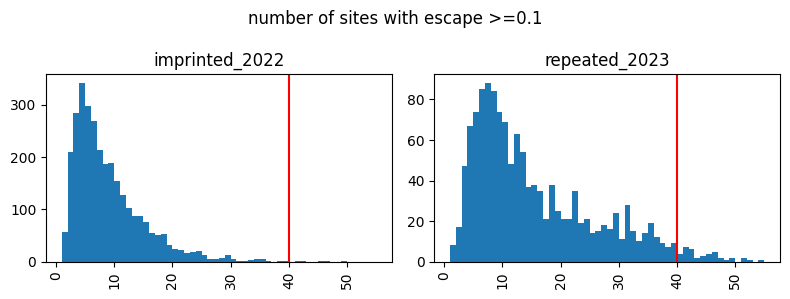

,antibody,site,escape,study
0,BD30-604,335,0.049379,repeated_2023
1,BD30-604,340,0.051323,repeated_2023
2,BD30-604,346,0.032896,repeated_2023
3,BD30-604,365,0.072947,repeated_2023
4,BD30-604,370,0.039942,repeated_2023
...,...,...,...,...
115708,XGv-422,465,0.229740,imprinted_2022
115709,XGv-422,466,0.264641,imprinted_2022
115710,XGv-422,468,0.093587,imprinted_2022
115711,XGv-422,484,0.049302,imprinted_2022


Escape measurements for each study:


,n
study,
imprinted_2022,63066
repeated_2023,52647


In [9]:
escape = (
    pd.concat(
        [
            # get just antibodies from that study
            escape_df.merge(antibody_source.query("study == @study")[["antibody"]])
            for study, escape_df in [
                ("repeated_2023", repeated_2023_escape),
                ("imprinted_2022", imprinted_2022_escape),
            ]
        ],
        ignore_index=True,
    )
    .assign(
        escape=lambda x: (
            x["escape"] / x.groupby(["antibody", "study"])["escape"].transform("max")
        )
    )
)

# get and plot sites with escape above 0.1, then eliminate antibodies with
# too many sites of substantial escape
sig_escape_threshold = 0.1  # plot sites with at least this much escape
max_sig_sites = 40
n_sig_escape = (
    escape
    .query("escape >= @sig_escape_threshold")
    .groupby(["antibody", "study"], as_index=False)
    .aggregate(n_sites=pd.NamedAgg("site", "nunique"))
)

ncols = 2
nrows = int(math.ceil(n_sig_escape["study"].nunique()) / ncols)
axes = n_sig_escape.hist(
    column="n_sites",
    by="study",
    bins=range(1, n_sig_escape["n_sites"].max() + 1, 1),
    grid=False,
    layout=(nrows, ncols),
    figsize=(4 * ncols, 3 * nrows),
)
for ax in axes:
    ax.axvline(max_sig_sites, color="red")
fig = plt.gcf()
fig.suptitle(f"number of sites with escape >={sig_escape_threshold}")
fig.tight_layout()
plt.show(plt.gcf())

# drop antibodies with too many sites of escape
escape = (
    escape
    .merge(
        n_sig_escape.query("n_sites <= @max_sig_sites")[["antibody", "study"]],
        how="inner",
        validate="many_to_one",
    )
)
    
assert escape["antibody"].nunique() == len(escape.groupby(["antibody", "study"]))

display(escape)

print("Escape measurements for each study:")
display(escape.groupby("study").aggregate(n=pd.NamedAgg("site", "count")))

Only keep the antibodies that have all types of measurements when writing files in next cell:

In [10]:
antibodies = (
    antibody_source
    [["antibody"]]
    .assign(has_source=True)
    .drop_duplicates()
    .merge(
        antibody_ic50s[["antibody"]].assign(has_ic50=True).drop_duplicates(),
        how="outer",
        validate="one_to_one",
    )
    .merge(
        antibody_binding[["antibody"]].assign(has_binding=True).drop_duplicates(),
        how="outer",
        validate="one_to_one",
    )
    .merge(
        escape[["antibody"]].assign(has_escape=True).drop_duplicates(),
        how="outer",
        validate="one_to_one",
    )
    .set_index("antibody")
    .fillna(False)
    .assign(has_all=lambda x: x.all(axis=1))
    .reset_index()
)

print("This many antibodies have all measurements:")
display(
    antibodies
    .groupby([c for c in antibodies.columns if c != "antibody"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "count"))
)

antibodies_to_keep = set(antibodies.query("has_all")["antibody"])

This many antibodies have all measurements:


n_antibodies
has_source has_ic50 has_binding has_escape has_all              
True       True     False       True       False               1
                    True        False      False             323
                                True       True             4353

Write the output files, only with antibodies to keep:

In [11]:
os.makedirs("results", exist_ok=True)

(
    antibody_source
    .query("antibody in @antibodies_to_keep")
    .to_csv("results/antibody_sources.csv", index=False)
)

(
    antibody_ic50s
    .query("antibody in @antibodies_to_keep")
    .drop(columns="study")
    .to_csv("results/antibody_IC50s.csv", index=False)
)

(
    antibody_binding
    .query("antibody in @antibodies_to_keep")
    .drop(columns="study")
    .to_csv("results/antibody_binding.csv", index=False)
)

escape.drop(columns="study").to_csv("results/escape.csv", float_format="%.4g", index=False)